In [1]:
#importing modules
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
import math


In [2]:
# Reading the arc_tax file and splitting the arc_tax file into different columns of taxa

arc_tax = pd.read_csv("ar122_taxonomy_r89.tsv", sep = "\t", names = ["no", "taxa"])


# split the  file rows using the split command
arc_tax_split = arc_tax["taxa"].str.split('d__', expand = True)
arc_tax_split = arc_tax_split[1].str.split(';[a-z]__', expand = True)
header = ['domain', 'phylum', 'class', 'order', 'family', 'genus', 'species']
arc_tax_split.columns = header
arc_tax_split["id"] = arc_tax["no"]


# Splitting the columns that contain only the refseq
arc_tax_split_refseq = arc_tax_split.loc[arc_tax_split["id"].str.contains("GCF")]

# Reading  and splitting the  MAGs taxonomy file
mag_tax = pd.read_csv("genome_metadata.tsv", sep = "\t")
mag_tax = mag_tax[["genome_id", "ecosystem", "habitat", "otu_id"]]
mag_tax_split = mag_tax["ecosystem"].str.split('d__', expand = True)
mag_tax_split = mag_tax_split[1].str.split(';[a-z]__', expand = True)
header = ['domain', 'phylum', 'class', 'order', 'family', 'genus', 'species']
mag_tax_split.columns = header
mag_tax_split["genome_id"] = mag_tax["genome_id"]
mag_tax_split["habitat"] = mag_tax["habitat"]

mag_tax_split.head()
arc_mag_tax = mag_tax_split[(mag_tax_split.domain == "Archaea")]
arc_mag_tax = arc_mag_tax.rename(columns= {"class": "CLASS"})

#list of each taxa levels in the refseq

#list of domain
domain_list = arc_tax_split_refseq.domain.value_counts().index
# list of phylum
phylum_list = arc_tax_split_refseq.phylum.value_counts().index
#list of class
class_list = arc_tax_split_refseq["class"].value_counts().index
#list of order
order_list = arc_tax_split_refseq.order.value_counts().index
# list of family
family_list = arc_tax_split_refseq.family.value_counts().index
# list of genus
genus_list = arc_tax_split_refseq.genus.value_counts().index
# list of species 
species_list = arc_tax_split_refseq.genus.value_counts().index

#  Calculating the species level, GCF tags are the Refseq species  
species_level = arc_mag_tax.species.str.contains("GCF", na = False)
species_level.value_counts()

#filter those that do  contain species and assign the value of 0 to taxonomic dist and species to cultured level
species_data = arc_mag_tax.loc[species_level]
species_data["taxonomic_dist"] = 0
species_data["cultured_level"] = "Species"
species_data.head()

# filter those with no species(false) and continue with that dataframe to look for the genus level

mag_without_species = arc_mag_tax.loc[~species_level]
genus_level = mag_without_species.genus.isin(genus_list)
genus_level.value_counts()
genus_data = mag_without_species.loc[genus_level]
genus_data["taxonomic_dist"] = 1
genus_data["cultured_level"] = "Genus"
genus_data.head


# filter those with no genus(false) and continue with that dataframe to look for family

mag_without_genus = mag_without_species.loc[~genus_level]
family_level = mag_without_genus.family.isin(family_list)
family_level.value_counts()
family_data = mag_without_genus.loc[family_level]
family_data["taxonomic_dist"] = 2
family_data["cultured_level"] = "Family"
family_data.head

# filter those with no family(false) and continue with that dataframe to look for order
mag_without_family = mag_without_genus.loc[~family_level]
order_level = mag_without_family.order.isin(order_list)
order_level.value_counts()
order_data = mag_without_family.loc[order_level]
order_data["taxonomic_dist"] = 3
order_data["cultured_level"] = "Order"
order_data.head

# filter those with no order(false) and continue with that dataframe to look for class
mag_without_order = mag_without_family.loc[~order_level]
class_level = mag_without_order.CLASS.isin(class_list)
class_level.value_counts()
class_data = mag_without_order.loc[class_level]
class_data["taxonomic_dist"] = 4
class_data["cultured_level"] = "CLASS"
class_data.head

# filter those with no class(false) and continue with that dataframe to look for phylum
mag_without_class = mag_without_order.loc[~class_level]
phylum_level = mag_without_class.phylum.isin(phylum_list)
phylum_level.value_counts()
phylum_data = mag_without_class.loc[phylum_level]
phylum_data["taxonomic_dist"] = 5
phylum_data["cultured_level"] = "Phylum"
phylum_data.head

# filter those with no phylum(false) and continue with that dataframe to look for domain
mag_without_phylum = mag_without_class.loc[~phylum_level]
domain_level = mag_without_phylum.domain.isin(domain_list)
domain_level.value_counts()
domain_data = mag_without_phylum.loc[domain_level]
domain_data["taxonomic_dist"] = 6
domain_data["cultured_level"] = "Domain"
domain_data.head

# merging all the data together
all_level = [species_data, genus_data, family_data, class_data, phylum_data, domain_data, order_data]

arc_mag_level = pd.concat(all_level)

# Reading  the data with the similarity scores information from Diamond
diamond_tax = pd.read_csv("Bitscore_file.csv", sep = ",")

# Reading  the arc_mag_level  with the similarity scores information from Diamond
diamond_arc_mag = arc_mag_level.merge(diamond_tax, left_on ='genome_id', right_on='genome_id')
# Normalizing the bitscores by dividing with the Alignment length
diamond_arc_mag ["norm_bitscore"] = diamond_arc_mag["Bit_score"]/diamond_arc_mag["Alignment_Length"]
# Normalizing the bitscores by taking the log10
diamond_arc_mag ["log_bitscore"] = np.log10(diamond_arc_mag["Bit_score"])
# Make 1000 samples and visualize taxonomic dist., bitscores and cultured level 
samp_diamond_arc_mag = diamond_arc_mag.sample(n=1000, random_state=1)


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

Text(0.5, 0.98, 'Bit scores distribution of Archaea MAGS')

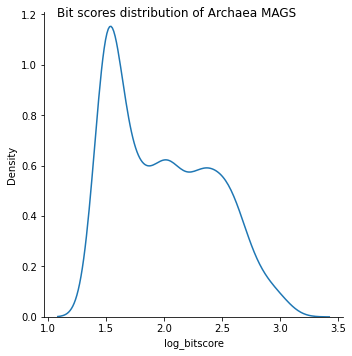

In [3]:
# Bitscore distribution of archaea MAGs
p = sns.displot(samp_diamond_arc_mag, x="log_bitscore", kind="kde")
p.fig.suptitle("Bit scores distribution of Archaea MAGS")

R-squared: 0.014926


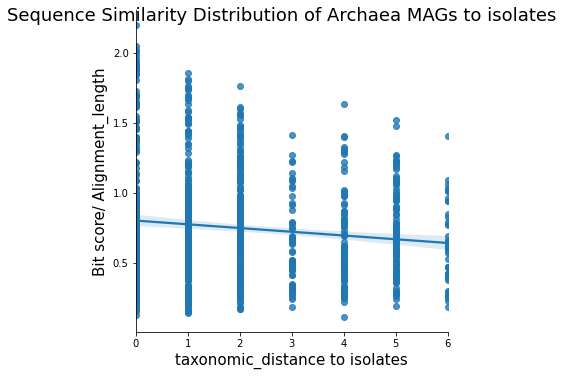

In [4]:
# Calculating the relationship between taxonomic distance  and norm_bitscore
p = sns.lmplot(x='taxonomic_dist', y='norm_bitscore', data = samp_diamond_arc_mag)
p.set_ylabels('Bit score/ Alignment_length', fontsize=15) 
p.set_xlabels('taxonomic_distance to isolates', fontsize=15)
p.fig.suptitle("Sequence Similarity Distribution of Archaea MAGs to isolates", fontsize = 18)
# Calculating the regression 
res_1 = stats.linregress(samp_diamond_arc_mag["taxonomic_dist"], samp_diamond_arc_mag["norm_bitscore"])
print(f"R-squared: {res_1.rvalue**2:.6f}")

R-squared: 0.002899


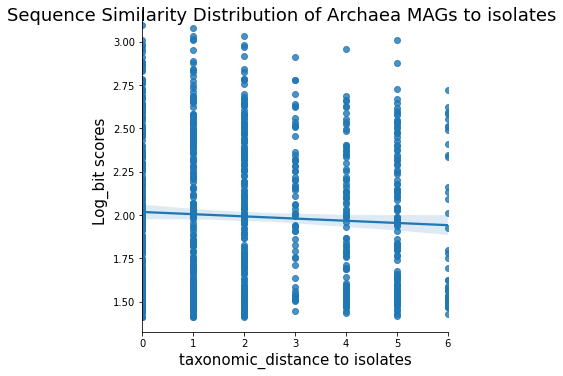

In [5]:
# Calculating the relationship between taxonomic distance  and norm_bitscore(log_bitscores approach)

p = sns.lmplot(x='taxonomic_dist', y='log_bitscore', data = samp_diamond_arc_mag)
p.set_ylabels('Log_bit scores', fontsize=15) # not set_label
p.set_xlabels('taxonomic_distance to isolates', fontsize=15)
p.fig.suptitle("Sequence Similarity Distribution of Archaea MAGs to isolates", fontsize = 18)
# Calculating the regression 
res_2 = stats.linregress(samp_diamond_arc_mag["taxonomic_dist"], samp_diamond_arc_mag["log_bitscore"])
print(f"R-squared: {res_2.rvalue**2:.6f}")

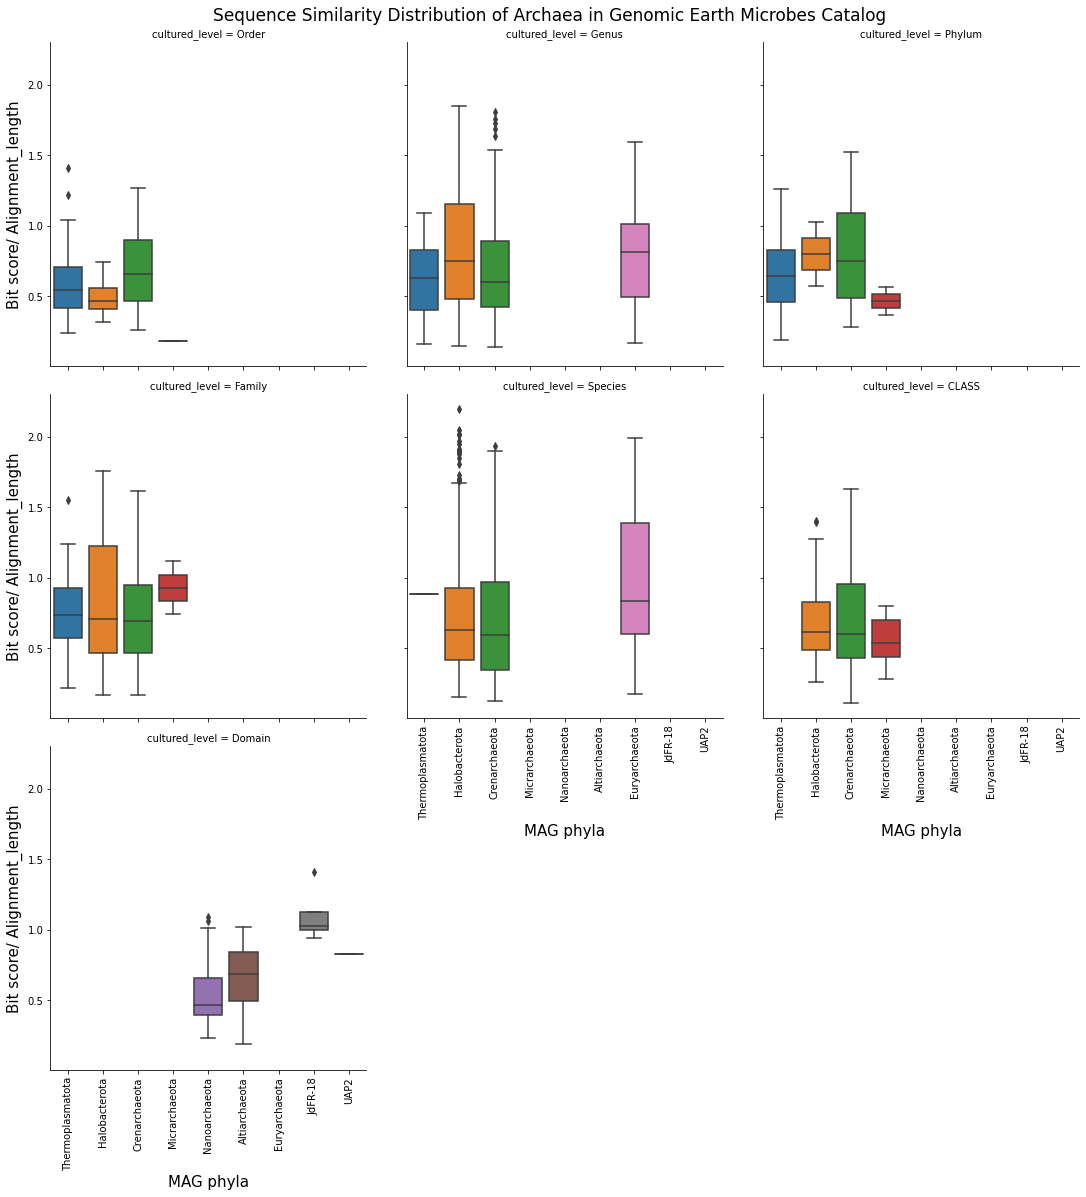

In [8]:
# Boxplot to show the relationship between cultured level, phylum and sequence similarity for 1000 samples from the Archaea data
p = sns.catplot(
    data= samp_diamond_arc_mag, x='phylum', y='norm_bitscore',
    col='cultured_level', kind='box', col_wrap=3
) 


p.fig.suptitle("Sequence Similarity Distribution of Archaea in Genomic Earth Microbes Catalog\n", y = 1.01, fontsize = 17)
p.set_ylabels('Bit score/ Alignment_length', fontsize=15) # not set_label
p.set_xlabels('MAG phyla', fontsize=15)
p.set_xticklabels(rotation=90)

In [9]:
# We want to consider the relationship in  only the dominant MAG phyla here
#Make 1000 samples of each  of the dominant six  MAG phlya
diamond_arc_mag["phylum"].value_counts()
arc_halo = diamond_arc_mag.loc[(diamond_arc_mag.phylum == "Halobacterota")]
samp_arc_halo = arc_halo.sample(n=1000, random_state=1)
arc_cre = diamond_arc_mag.loc[(diamond_arc_mag.phylum == "Crenarchaeota")]  
samp_arc_cre = arc_cre.sample(n=1000, random_state=1)
arc_ther = diamond_arc_mag.loc[(diamond_arc_mag.phylum == "Thermoplasmatota")]  
samp_arc_ther = arc_ther.sample(n=1000, random_state=1)
arc_eur = diamond_arc_mag.loc[(diamond_arc_mag.phylum == "Euryarchaeota")]  
samp_arc_eur = arc_eur.sample(n=1000, random_state=1)
arc_nano = diamond_arc_mag.loc[(diamond_arc_mag.phylum == "Nanoarchaeota")]  
samp_arc_nano = arc_nano.sample(n=1000, random_state=1)
arc_micr = diamond_arc_mag.loc[(diamond_arc_mag.phylum == "Micrarchaeota")]  
samp_arc_micr = arc_micr.sample(n=1000, random_state=1)

all_phyla_samp = [samp_arc_cre, samp_arc_ther, samp_arc_eur,  samp_arc_nano, samp_arc_micr, samp_arc_halo]

arc_phyla_samp = pd.concat(all_phyla_samp)


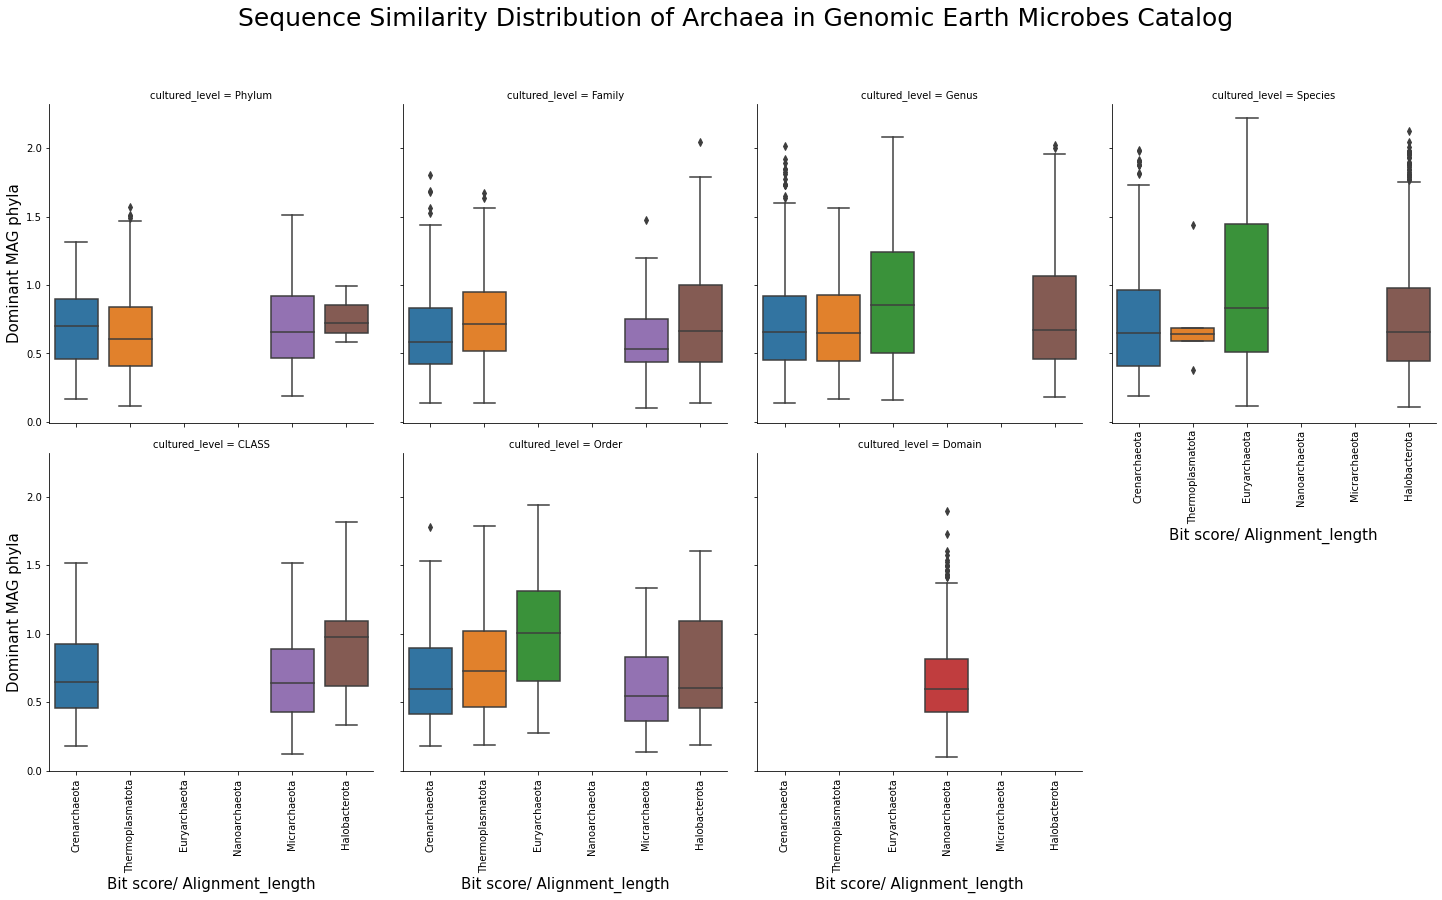

In [10]:
# Boxplot to show the relationships in the samples of the  six dominant phyla
p = sns.catplot(
    data= arc_phyla_samp, x='phylum', y='norm_bitscore',
    col='cultured_level', kind='box', col_wrap=4
) 


p.fig.suptitle("Sequence Similarity Distribution of Archaea in Genomic Earth Microbes Catalog\n", y = 1.1, fontsize = 25)
p.set_xlabels('Bit score/ Alignment_length', fontsize=15) # not set_label
p.set_ylabels('Dominant MAG phyla', fontsize=15)
p.set_xticklabels(rotation=90)